# Linear Regression: predicting house prices

(Data set: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering.
- Split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- House prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### Baseline Model:

Quality, size and age of a house affect house price. The better the quality, the larger the house, the younger the house -- the higher the house price. We'll test this assumption by using linear regression and Ridge, LASSO or ElasticNet regression techniques.
### Additional Data:

Interest rates, population shifts, population income, and the availability of housing units affect house prices. We'll test this by adding economic data and running a new linear regression model.

In [1]:
import numpy as np
import pandas as pd

from scipy.stats.mstats import winsorize
from scipy.stats import boxcox

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Part I - Original Dataset

### Data Cleaning, EDA, Feature Engineering

In [3]:
hp_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
#hp_df.info()

In [5]:
# get percentage of missing values:
#(hp_df.isnull().sum()*100/hp_df.isnull().count()).sort_values(ascending=False)

In [6]:
# drop variables with a lot of misisng values:
hp_df = hp_df.drop(['poolqc',
                    'miscfeature',
                   'alley',
                   'fence',
                   'fireplacequ'], axis=1)

In [7]:
# get all variables with numeric values:
numeric = hp_df.select_dtypes(['int64', 'float64']).columns

# get all variables that have string values:
string = hp_df.select_dtypes(['object']).columns

In [8]:
# impute data in the numeric variable by getting average values:
hp_df['lotfrontage'].fillna(hp_df['lotfrontage'].mean(), inplace=True)

In [9]:
# review unique values to get a sense of possible issues with data:
# for column_name in hp_df.columns:
#     print("Unique values in column {} are: {}"
#           .format(column_name, hp_df[column_name].unique()))

### Target Variable

**saleprice** is our target variable.

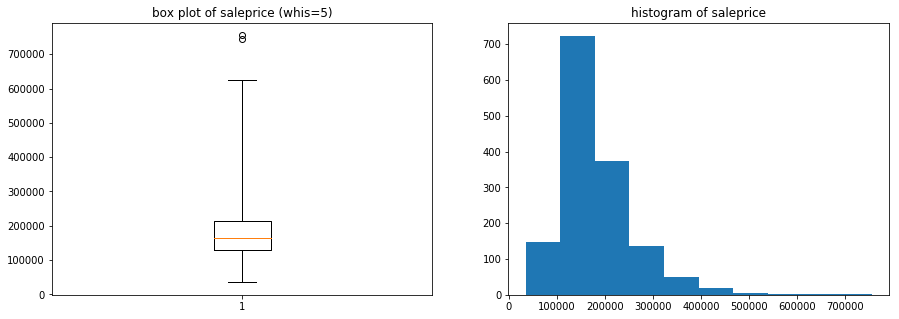

In [10]:
# review outliers and the distribution of our target variable:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(hp_df['saleprice'], whis=5)
plt.title('box plot of saleprice (whis=5)')

plt.subplot(1,2,2)
plt.hist(hp_df['saleprice'])
plt.title('histogram of saleprice')
plt.show()

In [11]:
# winsorize the target variable to address outliers
hp_df['saleprice'] = winsorize(hp_df['saleprice'], (0.01, 0.02))

In [12]:
# log-transform the target variable to address non-normality of distribution:
hp_df['saleprice'] = np.log(hp_df['saleprice'])

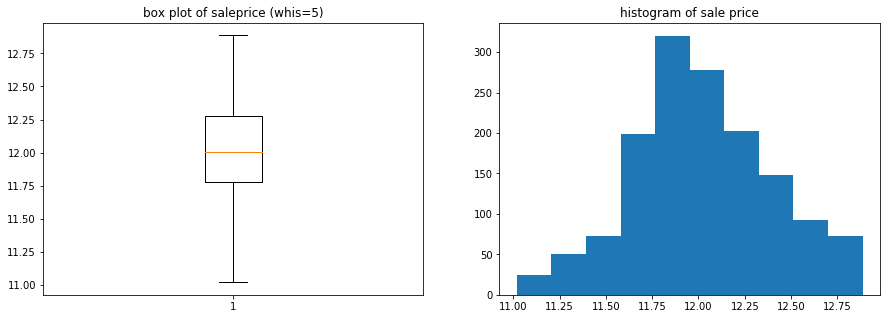

In [13]:
# review outliers and the distribution of our transformed target variable:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(hp_df['saleprice'], whis=5)
plt.title('box plot of saleprice (whis=5)')

plt.subplot(1,2,2)
plt.hist(hp_df['saleprice'])
plt.title('histogram of sale price')
plt.show()

After applying winsorization and log transformation, we have no outliers and variable is better distributed.

### Explanatory Variables

Review correlation of variables with our target variable, identify continuous and categorical data, transform variables to address outliers and non-normality of distribution, and make all variables numeric.

In [14]:
# Review correlation of the target variable with numeric variables:
hp_df_numeric = hp_df[hp_df.columns[1:]].corr()['saleprice'][:]
hp_df_numeric.sort_values(ascending=False)

saleprice        1.000
overallqual      0.817
grlivarea        0.693
garagecars       0.684
garagearea       0.653
totalbsmtsf      0.608
yearbuilt        0.596
fullbath         0.596
firstflrsf       0.591
yearremodadd     0.573
garageyrblt      0.547
totrmsabvgrd     0.528
fireplaces       0.492
masvnrarea       0.421
bsmtfinsf1       0.366
wooddecksf       0.336
lotfrontage      0.334
openporchsf      0.332
secondflrsf      0.315
halfbath         0.314
lotarea          0.257
bsmtfullbath     0.240
bsmtunfsf        0.224
bedroomabvgr     0.206
screenporch      0.119
mosold           0.065
threessnporch    0.058
poolarea         0.057
bsmtfinsf2       0.004
bsmthalfbath    -0.009
miscval         -0.019
yrsold          -0.038
overallcond     -0.042
lowqualfinsf    -0.043
mssubclass      -0.077
enclosedporch   -0.151
kitchenabvgr    -0.152
Name: saleprice, dtype: float64

Below are some of the variables with highest correlation (> 0.5) (some of these are technically categorical variables):

- overallqual - Overall material and finish quality
- grlivarea - Above grade (ground) living area square feet
- garagecars - Size of garage in car capacity
- garagearea - Size of garage in square feet
- totalbsmtsf - Total square feet of basement area
- firstflrsf - First Floor square feet
- fullbath - Full bathrooms above grade
- totrmsabvgrd - Total rooms above grade (does not include bathrooms)
- yearbuilt - Original construction date
- yearremodadd - Remodel date

Some possible derivative variables:

- totalsf = firstflrsf + secondflrsf (and then compare correlation with grlivarea).

In [15]:
# calculate total square footage:
hp_df['totalsf'] = hp_df['firstflrsf'] + hp_df['secondflrsf']

# create a dataframe of possible features:
features = hp_df[['overallqual', 'grlivarea', 'garagecars',
          'garagearea', 'totalbsmtsf', 'totalsf', 'fullbath', 'totrmsabvgrd',
                 'yearbuilt', 'yearremodadd']]
features.head()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,totalsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd
0,7,1710,2,548,856,1710,2,8,2003,2003
1,6,1262,2,460,1262,1262,2,6,1976,1976
2,7,1786,2,608,920,1786,2,6,2001,2002
3,7,1717,3,642,756,1717,1,7,1915,1970
4,8,2198,3,836,1145,2198,2,9,2000,2000


In [16]:
#features.describe()

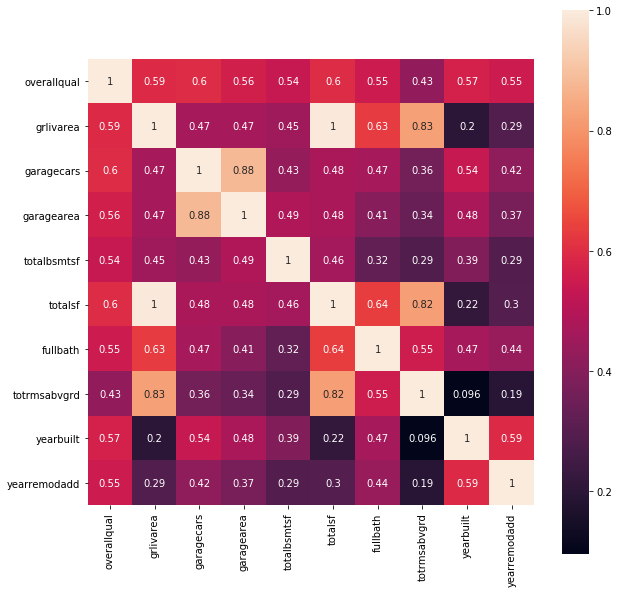

In [17]:
# review correlation of the features:
plt.figure(figsize=(10,10))
features_corr = features.corr()
sns.heatmap(features_corr, annot=True, square=True)

In [18]:
# drop variables higly correlated with others:
features = features.drop(['totalsf',
                         'garagecars',
                         'totrmsabvgrd'], axis=1)

**overallqual** can be considered both categorical (it takes on 10 values), and continous (quality of "10" is higher than quality of "1"). We'll keep this variable as is.


In [19]:
features['fullbath'].value_counts()

2    768
1    650
3     33
0      9
Name: fullbath, dtype: int64

**fullbath** seems like categorical variable with only a few options; 0, 1, 2 or 3 full bathrooms. Zero full bathrooms could be data entry errors, but this is uncertain. We'll create a new category with "1" meaning "more than one fullbath" and "0" meaning "one fullbath or less."

In [20]:
more1_fullbath = features['fullbath'] > 1
print(more1_fullbath.value_counts())
features['fullbath'] = more1_fullbath.replace(True, 'more1_fullbath').replace(False, 'one_fullbath')
features = pd.concat([features, pd.get_dummies(features['fullbath'])], axis=1)
features = features.drop('fullbath', axis=1).drop('one_fullbath', axis=1)
#features.head()

True     801
False    659
Name: fullbath, dtype: int64



We'll turn **yearbuilt**, **yearremodadd** into dummy variables.

<function matplotlib.pyplot.show(*args, **kw)>

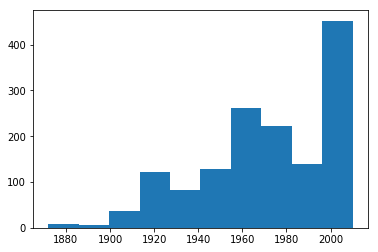

In [21]:
plt.hist(features['yearbuilt'])
plt.show

In [22]:
yearbuilt_after1960 = features['yearbuilt'] > 1960
yearbuilt_after1960.value_counts()

True     958
False    502
Name: yearbuilt, dtype: int64

In [23]:
features['yearbuilt'] = yearbuilt_after1960.replace(True, 'yearbuilt_after1960').replace(False, 'before1960')
features = pd.concat([features, pd.get_dummies(features['yearbuilt'])],axis=1)
features = features.drop('yearbuilt', axis=1).drop('before1960', axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

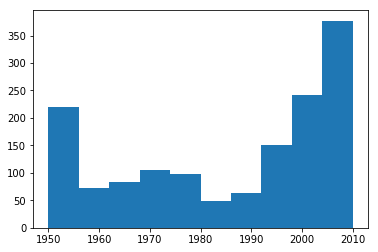

In [24]:
plt.hist(features['yearremodadd'])
plt.show

In [25]:
yearremodadd_after1990 = features['yearremodadd'] > 1990
yearremodadd_after1990.value_counts()

True     782
False    678
Name: yearremodadd, dtype: int64

In [26]:
features['yearremodadd'] = yearremodadd_after1990.replace(True, 'yearremodadd_after1990').replace(False, 'after1990')
features = pd.concat([features, pd.get_dummies(features['yearremodadd'])],axis=1)
features = features.drop('yearremodadd', axis=1).drop('after1990', axis=1)
features.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990
0,7,1710,548,856,1,1,1
1,6,1262,460,1262,1,1,0
2,7,1786,608,920,1,1,1
3,7,1717,642,756,0,0,0
4,8,2198,836,1145,1,1,1


To even out the weight among the variables, we'll use sqrt to transform continous variables that measure area.

In [27]:
features['grlivarea'] = np.sqrt(features['grlivarea'])
features['garagearea'] = np.sqrt(features['garagearea'])
features['totalbsmtsf'] = np.sqrt(features['totalbsmtsf'])
features.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990
0,7,41.352,23.409,29.257,1,1,1
1,6,35.525,21.448,35.525,1,1,0
2,7,42.261,24.658,30.332,1,1,1
3,7,41.437,25.338,27.495,0,0,0
4,8,46.883,28.914,33.838,1,1,1


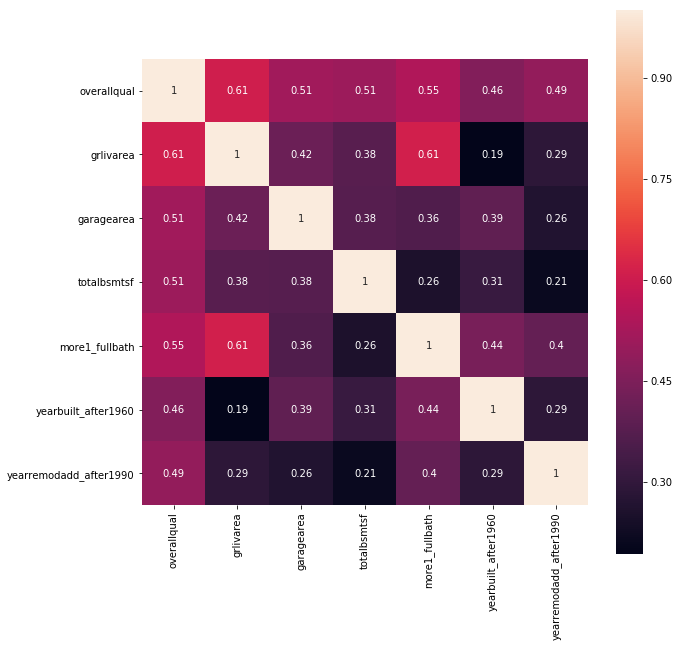

In [28]:
# Review correlation of the features:
plt.figure(figsize=(10,10))
features_corr = features.corr()
sns.heatmap(features_corr, annot=True, square=True)

Selected features:

- overallqual - Overall material and finish quality
- grlivarea - Above grade (ground) living area square feet
- garagearea - Size of garage in square feet
- totalbsmtsf - Total square feet of basement area
- more1_fullbath - More than one full bathrooms above grade (may be dropped later)
- yearbuilt_after1960 - Original construction date is after 1960
- yearremodadd_after1990 - Remodel date is after 1990

Text(0.5, 1.0, 'Box plot of totalbsmtsf (whis=5)')

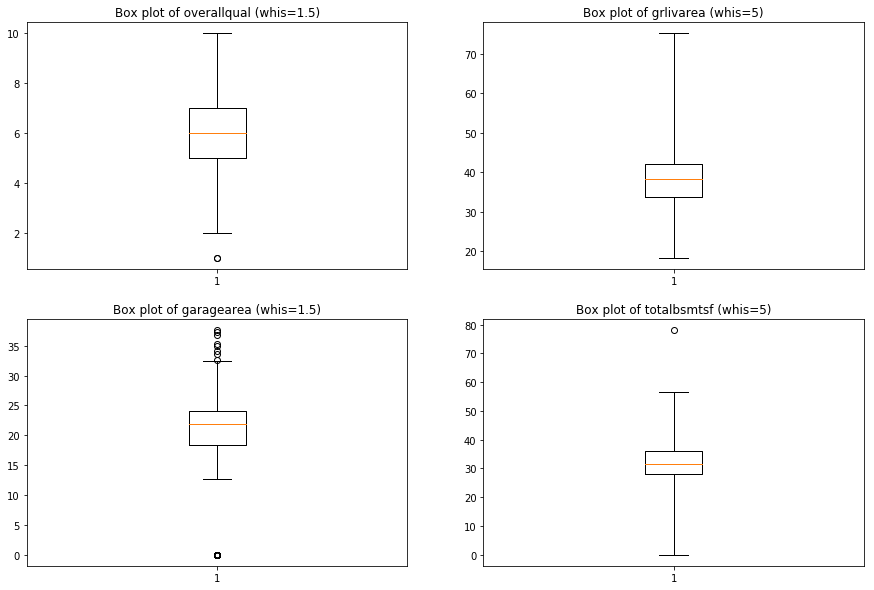

In [29]:
# plot features to review outliers:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.boxplot(features['overallqual'], whis=1.5)
plt.title('Box plot of overallqual (whis=1.5)')

plt.subplot(2,2,2)
plt.boxplot(features['grlivarea'], whis=5)
plt.title('Box plot of grlivarea (whis=5)')

plt.subplot(2,2,3)
plt.boxplot(features['garagearea'], whis=1.5)
plt.title('Box plot of garagearea (whis=1.5)')

plt.subplot(2,2,4)
plt.boxplot(features['totalbsmtsf'], whis=5)
plt.title('Box plot of totalbsmtsf (whis=5)')

In [30]:
# winsorize a few variables to address outliers:
overallqual_w = winsorize(features['overallqual'], (0.01, 0))
garagearea_w = winsorize(features['garagearea'], (0, 0.05))
totalbsmtsf_w = winsorize(features['totalbsmtsf'], (0, 0.001))

Text(0.5, 1.0, 'Box plot of totalbsmtsf_w (whis=5)')

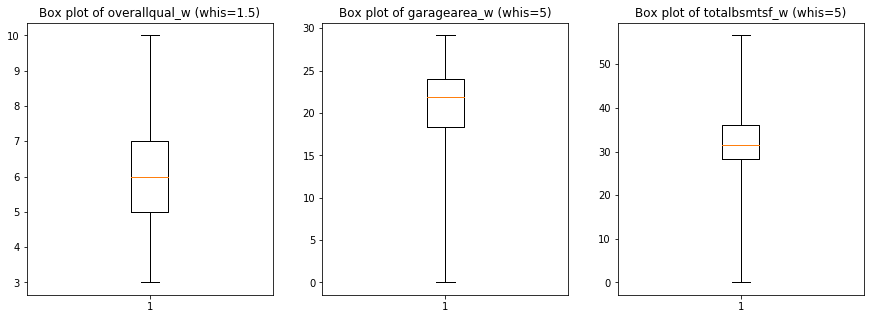

In [31]:
# review features after winsorization:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(overallqual_w, whis=1.5)
plt.title('Box plot of overallqual_w (whis=1.5)')

plt.subplot(1,3,2)
plt.boxplot(garagearea_w, whis=5)
plt.title('Box plot of garagearea_w (whis=5)')

plt.subplot(1,3,3)
plt.boxplot(totalbsmtsf_w, whis=5)
plt.title('Box plot of totalbsmtsf_w (whis=5)')

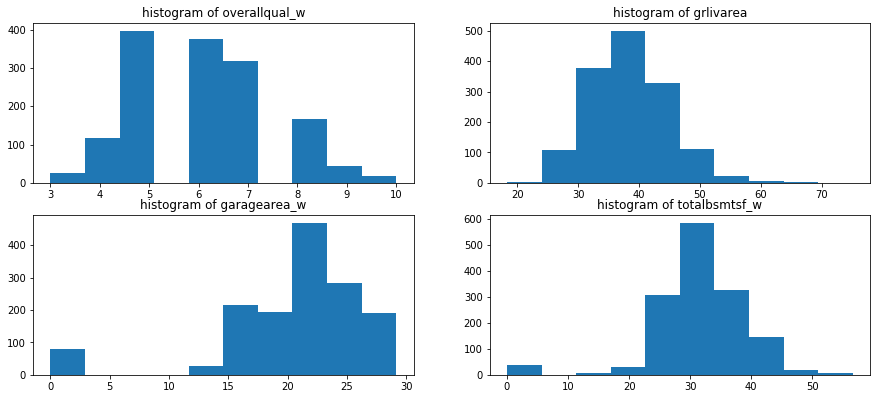

In [32]:
# review distribution: 
plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.hist(overallqual_w)
plt.title('histogram of overallqual_w')

plt.subplot(3, 2, 2)
plt.hist(features['grlivarea'])
plt.title('histogram of grlivarea')

plt.subplot(3, 2, 3)
plt.hist(garagearea_w)
plt.title('histogram of garagearea_w')

plt.subplot(3, 2, 4)
plt.hist(totalbsmtsf_w)
plt.title('histogram of totalbsmtsf_w')

plt.show()

garagearea_w and totalbsmtsf_w have some zero values because some houses don't have garages or basements.

In [33]:
# create dataframe for the model that includes the target variable and features:
norm_df = features.copy()
norm_df['saleprice'] = hp_df['saleprice']
norm_df.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice
0,7,41.352,23.409,29.257,1,1,1,12.248
1,6,35.525,21.448,35.525,1,1,0,12.109
2,7,42.261,24.658,30.332,1,1,1,12.317
3,7,41.437,25.338,27.495,0,0,0,11.849
4,8,46.883,28.914,33.838,1,1,1,12.429


In [34]:
# standartize features:
norm_df['overallqual'] = scale(norm_df['overallqual'])
norm_df['grlivarea'] = scale(norm_df['grlivarea'])
norm_df['garagearea'] = scale(norm_df['garagearea'])
norm_df['totalbsmtsf'] = scale(norm_df['totalbsmtsf'])

norm_df.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice
0,0.651,0.459,0.410,-0.304,1,1,1,12.248
1,-0.072,-0.444,0.104,0.511,1,1,0,12.109
2,0.651,0.600,0.604,-0.164,1,1,1,12.317
3,0.651,0.472,0.710,-0.532,0,0,0,11.849
4,1.375,1.315,1.268,0.292,1,1,1,12.429


In [35]:
# Y is the target variable
Y = norm_df['saleprice']

# X is the feature set
X = norm_df[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf',
             'more1_fullbath', 'yearbuilt_after1960', 'yearremodadd_after1990']]

### Split Data into Train and Test Sets

In [36]:
# split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Linear Regression

In [37]:
# create a LinearRegression model object from scikit-learn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [0.13503382 0.12138053 0.05990645 0.05909351 0.0057665  0.0759023
 0.10343596]

Intercept: 
 11.913332684751465


The estimated model is:

    saleprice = 11.913332684751465 + 0.13503382overallqual + 0.12138053grlivarea
        + 0.05990645garagearea + 0.05909351totalbsmtsf + 0.0057665more1_fullbath
        + 0.0759023yearbuilt_after1960 + 0.10343596yearremodadd_after1990

In [38]:
# OLS gives us a nice summary results:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     726.4
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:30:43   Log-Likelihood:                 451.86
No. Observations:                1168   AIC:                            -887.7
Df Residuals:                    1160   BIC:                            -847.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

Estimated coefficients are similar to the one estimated by scikit-learn's model. 

According to adjusted R-Squared, 81.3% of variance in the target variable is explained by our model. AIC and BIC are low p-value of F-statistic is < 0.05, which means our model is useful in explaining saleprice. Out of all of the coefficients, more1_fullbath has a p-value of more than 0.05, which means there appears to be no relationship between saleprice and whether or not there were more than one full bathrooms in a house; we'll exclude it from our further analysis.


**Summary review of some linear regression assumptions:**

- Prob(Omnibus) shows the residuals are not normally distributed (should be 1).
- Skew is negative - data is asymmetric (should be close to 0).
- Kurtosis shows tight clustering of residuals around zero.
- Durbin-Watson shows homoscedasticity (should be between 1 and 2).
- Jarque-Bera should confirm Omnibus test.
- Cond. Number is ok, meaning there is no high multicollinearity.

Let's exclude **more1_fullbath** and re-estimate the model:

In [39]:
# Y is the target variable
Y = norm_df['saleprice']
# X is the feature set
X = norm_df[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf',
            'yearbuilt_after1960', 'yearremodadd_after1990']]

# split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [40]:
# create a LinearRegression model object from scikit-learn
lrm = LinearRegression()
# estimate coefficients using OLS
lrm.fit(X_train, y_train)
# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [0.13531618 0.12281668 0.05983581 0.05880047 0.07774852 0.10428264]

Intercept: 
 11.914810030496906


### Evaluate Model on Test Set

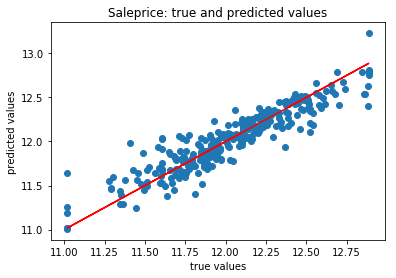

Score of the model in the training set is: 0.8142196490937887
Test set statistics:
Score of the model in the test set is: 0.8462315228940404
Mean squared error of the prediction is: 0.02301813153626437


In [41]:
# Evaluate model on the test set:
y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Saleprice: true and predicted values')
plt.show()

print('Score of the model in the training set is: {}'.format(lrm.score(X_train, y_train)))
print('Test set statistics:')
print('Score of the model in the test set is: {}'.format(lrm.score(X_test, y_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))

In [42]:
# use k-fold cross-validation to review the output of the model:
cross_val_score(lrm, X, Y, cv=5)

array([0.83483336, 0.82268087, 0.83650365, 0.84062154, 0.75068891])

MSE is 0.023018131536264336, which is pretty close to zero. 

Our linear regression model does better on the test set than on train set (85% vs. 81%). This may be due to test set having easier data points.

5-folds cross validation shows around 10 point difference.

Overall, there seems to be no underfitting or overfitting.

Given that our model generalizes well, we don't need to apply additional regression techniques such as Ridge, LASSO or ElasticNet regression. Below is an example of ElasticNet regression, the output of which is very similar to that of Linear our Regression model.

In [43]:
# ElasticNet regression:
elasticregr = ElasticNet(alpha=0.01, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print('R-squared of the model on the training set is: {}'.format(elasticregr.score(X_train, y_train)))
print('Test set statistics:')
print('R-squared of the model on the test set is: {}'.format(elasticregr.score(X_test, y_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))

R-squared of the model on the training set is: 0.8127350908467416
Test set statistics:
R-squared of the model on the test set is: 0.8416222761038783
Mean squared error of the prediction is: 0.023708105521153


# Pat II - Model with Additional Factors

We'll add a few economic indicators to our dataset and see how our linera regression model's performance changes.

In [44]:
# Create new dataframe with data on date of sale
new_df = norm_df.copy()
new_df['yrsold'] = hp_df['yrsold']
new_df['mosold'] = hp_df['mosold']
new_df.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice,yrsold,mosold
0,0.651,0.459,0.410,-0.304,1,1,1,12.248,2008,2
1,-0.072,-0.444,0.104,0.511,1,1,0,12.109,2007,5
2,0.651,0.600,0.604,-0.164,1,1,1,12.317,2008,9
3,0.651,0.472,0.710,-0.532,0,0,0,11.849,2006,2
4,1.375,1.315,1.268,0.292,1,1,1,12.429,2008,12


In [45]:
# check the dates for house sales in the dataset:
years = new_df['yrsold'].unique()
years

array([2008, 2007, 2006, 2009, 2010])

We'll add the following data for years 2006 to 2010:

Federal 30-Year Fixed-Rate Mortgage rates (http://www.freddiemac.com/pmms/pmms30.html):
- 2006-6.41, 2007-6.34, 2008-6.03, 2009-5.04, 2010-4.69


Iowa economic indicators (https://www.legis.iowa.gov/publications/fiscal/economicTrends):
- population: 2006-2,982,644; 2007-2,999,212; 2008-3,016,734; 2009-3,032,870; 2010-3,050,767 
- personal income summary: 2006-104274.9; 2007-112285.4; 2008-115292; 2009-114080.9; 2010-118496
- total housing units: 2006-12837; 2007-10733; 2008-7696; 2009-6957; 2010-7507

In [46]:
# create economic data dataframe:
data = {'yrsold': [2006, 2007, 2008, 2009, 2010],
       'rate': [6.41, 6.34, 6.03, 5.04, 4.69],
       'population': [2982644, 2999212, 3016734, 3032870, 3050767],
        'income': [104274.9, 112285.4, 115292, 114080.9, 118496],
        'units': [12837, 10733, 7696, 6957, 7507]}
economic_df = pd.DataFrame(data)
economic_df

,yrsold,rate,population,income,units
0,2006,6.410,2982644,104274.900,12837
1,2007,6.340,2999212,112285.400,10733
2,2008,6.030,3016734,115292.000,7696
3,2009,5.040,3032870,114080.900,6957
4,2010,4.690,3050767,118496.000,7507


In [47]:
merged_df = pd.merge(new_df, economic_df, on='yrsold')
merged_df.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice,yrsold,mosold,rate,population,income,units
0,0.651,0.459,0.410,-0.304,1,1,1,12.248,2008,2,6.030,3016734,115292.000,7696
1,0.651,0.600,0.604,-0.164,1,1,1,12.317,2008,9,6.030,3016734,115292.000,7696
2,1.375,1.315,1.268,0.292,1,1,1,12.429,2008,12,6.030,3016734,115292.000,7696
3,0.651,0.578,0.133,-0.096,1,0,0,11.775,2008,4,6.030,3016734,115292.000,7696
4,-0.795,-0.863,-1.007,-0.015,0,0,0,11.678,2008,1,6.030,3016734,115292.000,7696


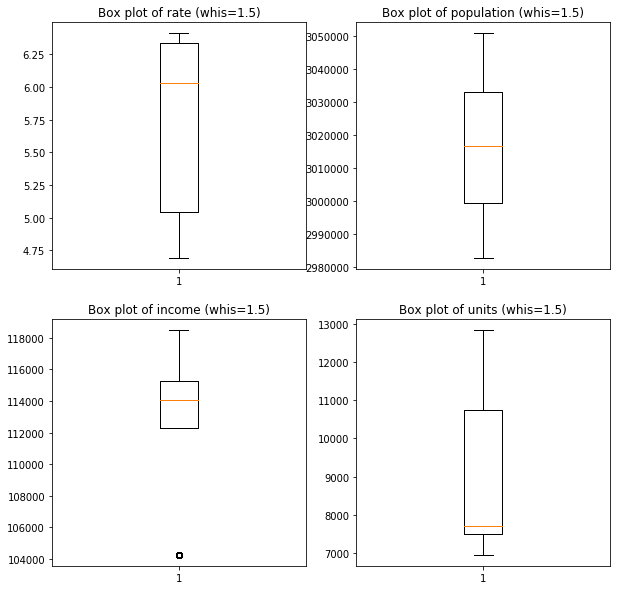

In [48]:
# review outliers in the new features:
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
plt.boxplot(merged_df['rate'], whis=1.5)
plt.title('Box plot of rate (whis=1.5)')

plt.subplot(2,2,2)
plt.boxplot(merged_df['population'], whis=1.5)
plt.title('Box plot of population (whis=1.5)')

plt.subplot(2,2,3)
plt.boxplot(merged_df['income'], whis=1.5)
plt.title('Box plot of income (whis=1.5)')

plt.subplot(2,2,4)
plt.boxplot(merged_df['units'], whis=1.5)
plt.title('Box plot of units (whis=1.5)')

plt.show()

Text(0.5, 1.0, 'Box plot of income_w (whis=1.5)')

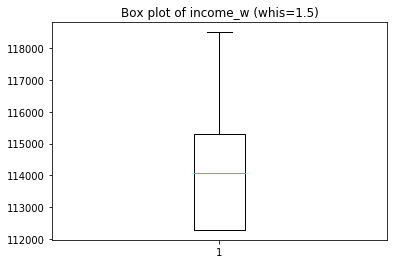

In [49]:
# even out income over years
income_w = winsorize(merged_df['income'], (0.23, 0))
plt.boxplot(income_w, whis=1.5)
plt.title('Box plot of income_w (whis=1.5)')

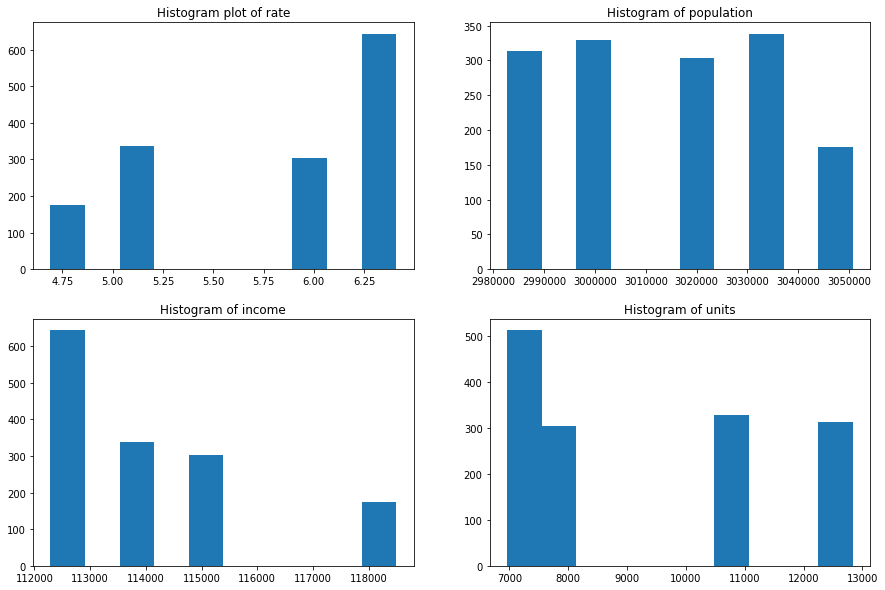

In [50]:
# review distribution of the new features:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.hist(merged_df['rate'])
plt.title('Histogram plot of rate')

plt.subplot(2,2,2)
plt.hist(merged_df['population'])
plt.title('Histogram of population')

plt.subplot(2,2,3)
plt.hist(income_w)
plt.title('Histogram of income')

plt.subplot(2,2,4)
plt.hist(merged_df['units'])
plt.title('Histogram of units')

plt.show()

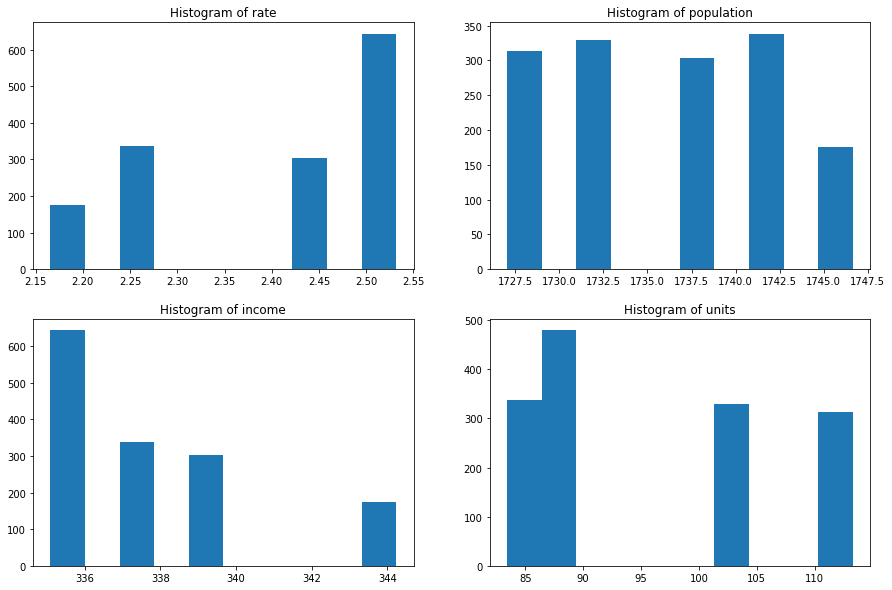

In [51]:
# try square root transformation:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.hist(np.sqrt(merged_df['rate']))
plt.title('Histogram of rate')

plt.subplot(2,2,2)
plt.hist(np.sqrt(merged_df['population']))
plt.title('Histogram of population')

plt.subplot(2,2,3)
plt.hist(np.sqrt(income_w))
plt.title('Histogram of income')

plt.subplot(2,2,4)
plt.hist(np.sqrt(merged_df['units']))
plt.title('Histogram of units')

plt.show()

In [52]:
norm_df2 = merged_df.copy()

In [53]:
norm_df2.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice,yrsold,mosold,rate,population,income,units
0,0.651,0.459,0.410,-0.304,1,1,1,12.248,2008,2,6.030,3016734,115292.000,7696
1,0.651,0.600,0.604,-0.164,1,1,1,12.317,2008,9,6.030,3016734,115292.000,7696
2,1.375,1.315,1.268,0.292,1,1,1,12.429,2008,12,6.030,3016734,115292.000,7696
3,0.651,0.578,0.133,-0.096,1,0,0,11.775,2008,4,6.030,3016734,115292.000,7696
4,-0.795,-0.863,-1.007,-0.015,0,0,0,11.678,2008,1,6.030,3016734,115292.000,7696


In [54]:
norm_df2['income'] = income_w

In [55]:
# standartize features:
norm_df2['rate'] = scale(norm_df2['rate'])
norm_df2['income'] = scale(np.sqrt(norm_df2['income']))
norm_df2['population'] = scale(np.sqrt(norm_df2['population']))
norm_df2['units'] = scale(np.sqrt(norm_df2['units']))

In [56]:
# drop variables higly correlated with others:
norm_df2 = norm_df2.drop(['yrsold',
                         'mosold'], axis=1)
norm_df2.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,more1_fullbath,yearbuilt_after1960,yearremodadd_after1990,saleprice,rate,population,income,units
0,0.651,0.459,0.410,-0.304,1,1,1,12.248,0.360,0.156,0.611,-0.675
1,0.651,0.600,0.604,-0.164,1,1,1,12.317,0.360,0.156,0.611,-0.675
2,1.375,1.315,1.268,0.292,1,1,1,12.429,0.360,0.156,0.611,-0.675
3,0.651,0.578,0.133,-0.096,1,0,0,11.775,0.360,0.156,0.611,-0.675
4,-0.795,-0.863,-1.007,-0.015,0,0,0,11.678,0.360,0.156,0.611,-0.675


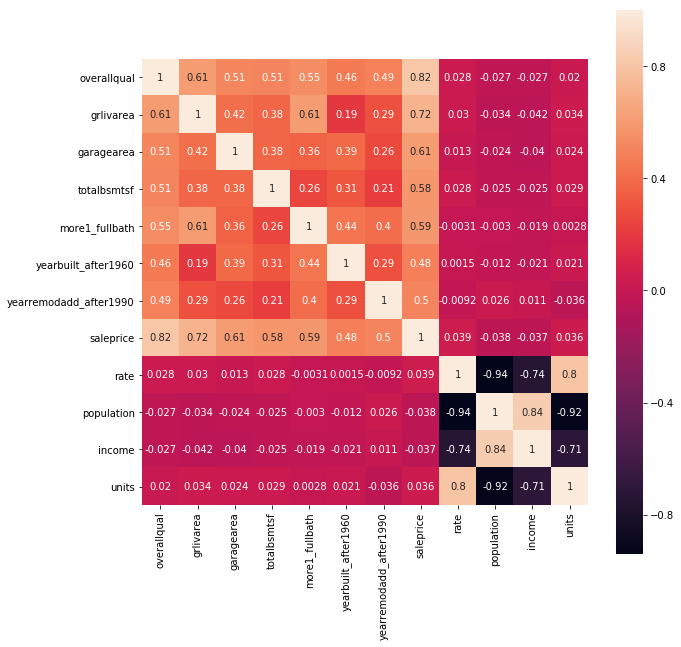

In [57]:
plt.figure(figsize=(10,10))
sns.heatmap(norm_df2.corr(), annot=True, square=True)

Rate and units are highly correlated. Population and income and are highly correlated. We'll only use rate and income as our additional features.

In [58]:
# Y is the target variable
Y = norm_df2['saleprice']

# X is the feature set
X = norm_df2[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf',
            'yearbuilt_after1960','yearremodadd_after1990', 'rate', 'income']]

# split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Linear Regression

In [59]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [0.13516652 0.11469183 0.06004902 0.06150769 0.08022281 0.11247511
 0.0112823  0.00559689]

Intercept: 
 11.908483785768594


Adding additional data slightly changed coefficients - it decreased some and increased some. Parameters of our first model on the original dataset:

"Coefficients: 
 [0.13531618 0.12281668 0.05983581 0.05880047 0.07774852 0.10428264]
 
Intercept: 
 11.914810030496906"

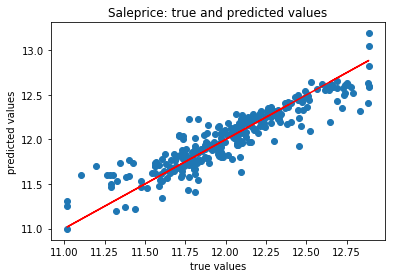

Score of the model in the training set is: 0.8194477195918802
Test set statistics:
Score of the model in the test set is: 0.8261384435300168
Mean squared error of the prediction is: 0.02560748351662728


In [60]:
# Evaluate model on the test set:
y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Saleprice: true and predicted values')
plt.show()

print('Score of the model in the training set is: {}'.format(lrm.score(X_train, y_train)))
print('Test set statistics:')
print('Score of the model in the test set is: {}'.format(lrm.score(X_test, y_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))

Score stayed in the same range with less difference between train and test data (82% and 83%). MSE is still low.

In [61]:
# review results using statsmodels
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     657.5
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:30:53   Log-Likelihood:                 465.86
No. Observations:                1168   AIC:                            -913.7
Df Residuals:                    1159   BIC:                            -868.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

**The p-values for the coefficients of interest rate and income are more than 0.05, which means there appears to be no relationship between interest rates and sale price and income and sale price.** This is an interesting finding, and could possibly be explained by the fact that maybe in Ames, Iowa, house prices do not depend on decreasing federal interest rate. 

### Summary

We built a linear regression model with a few features covering overall house quality, size of the house, garage and basement, as well as age of house/remodel date affecting sale prices. About 83% of variance in house sale prices can be explained by the model.

Adding economic data such as interest rate and population income did not improve the prediction performance of our model.